In [ ]:
%reload_ext autoreload
%autoreload 2
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
from tools.audio import *
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [ ]:
import random
files_path = r'audio'
files = librosa.util.find_files(files_path, ext=['wav'], recurse=True)
f = files[random.randint(0, len(files))]
f =  r'audio/3-253084-E-2.wav'
# Play the audio with sounddevice
import sounddevice as sd
# Load the audio file
audio, sr = read_audio(f)
spec = get_spectrogram(audio)
# Play the audio file
play_audio(audio, sr)

In [ ]:
n_masks = 9
T = 200

In [ ]:
spec_n_freq, spec_n_time = spec.shape[1], spec.shape[2]

In [ ]:
masks = torch.zeros(n_masks, spec_n_freq, spec_n_time).bool()
t = np.random.randint(0, T, n_masks) # [0, T)
t0 = np.random.randint(0, spec_n_time - t, n_masks) # [0, tau - t)
for i in range(n_masks):
    masks[i, :, t0[i]:t0[i] + t[i]] = True

In [ ]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(masks[i], origin='lower', cmap='jet', aspect='auto')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Apply the masks to the spectrogram
from tools.masking import create_freq_masks, create_time_masks, apply_masks
from tools.audio import get_spectrogram, read_audio, get_complex_spectrogram, inverse_complex_spectrogram

In [ ]:
# f = r'C:\Users\Diego\Documents\DTU\Fall2023\DL\Project\DL_RELAX\audio\sounds\1-19026-A-43.wav'
# f = r'C:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/audio/sounds/3-253084-E-2.wav'
# f = r'C:\Users\Diego\Documents\DTU\Fall2023\DL\Project\DL_RELAX\audio\sounds\5-221528-A-39.wav'
audio, sr = read_audio(f)
n_ftt = 2048
cpx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')

In [ ]:
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')


In [ ]:
T = 200
F = 200
n_masks = 500
n_ftt= 2048
time_masks = create_time_masks(cpx_spec.shape[1:3], T , n_masks)
freq_masks = create_freq_masks(cpx_spec.shape[1:3], F, n_masks)

In [ ]:
masked_spec_time = apply_masks(cpx_spec, time_masks)
masked_spec_freq = apply_masks(cpx_spec, freq_masks)
masked_audios_time = inverse_complex_spectrogram(masked_spec_time, n_ftt=n_ftt)
masked_audios_freq = inverse_complex_spectrogram(masked_spec_freq, n_ftt=n_ftt)
print(masked_audios_time.shape, masked_audios_time.dtype)
# print(masked_audios_freq.shape, masked_audios_freq.dtype)

In [ ]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(100):
    tmp_spec = get_spectrogram(masked_audios_time[i], n_ftt=n_ftt)
    tmp_spec = get_spectrogram(masked_audios_freq[i], n_ftt=n_ftt)
    tmp_spec_db = convert_to_db(tmp_spec)
    plt.subplot(10,10,i+1)
    plt.imshow(tmp_spec_db, origin='lower', cmap='jet', aspect='auto')
plt.show()

In [ ]:
# Play masked audio
ix_audio = 3
play_audio(masked_audios_freq[ix_audio], sr)

## Beats

In [ ]:
from tools.audio import resample_audio
from prediction import load_beats_model

In [ ]:
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios_freq, sr, 16000)

In [ ]:
import torch
masked_audio_inputs = torch.reshape(res_masked_audios, (n_masks, 1, res_masked_audios.shape[1]))

In [ ]:
masked_audio_inputs.shape

In [ ]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# Load BEATS model
model_path = 'beats_env/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

# Extract features of the original audio
h, _, _, h_prev  = beats_model.extract_features(res_audio)
h_star = h.expand(n_masks, -1)
h_star.shape, h.shape


In [ ]:
from tqdm import tqdm

In [ ]:
# Compute cosine similarity between original and masked features
import torch
from torch.nn.functional import cosine_similarity as cosine_sim
with torch.no_grad():
    W = torch.ones(tuple(time_masks.shape))
    R = torch.zeros(tuple(time_masks.shape))
    U = torch.zeros(tuple(time_masks.shape))
    for mask_idx, x_masked in tqdm(enumerate(masked_audio_inputs), total=n_masks):
        raw_mask = time_masks[mask_idx].float()
        W += raw_mask
        h_mask, _, _, _ = beats_model.extract_features(x_masked)
        s = cosine_sim(h, h_mask)
        R_prev = R
        R += raw_mask * (s - R) / W
        U += (s - R) * (s - R_prev) * raw_mask

In [ ]:
mean = torch.mean(R, dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Importance')
plt.title('Importance')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean = torch.mean(U/(W-1), dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Compute cosine similarity between original and masked features
from torch.nn.functional import cosine_similarity as cosine_sim
# Extract features of the masked audios
_, _, x, m_logits = beats_model.extract_features(masked_audio_inputs[1])

# Compute cosine similarity
cos_sim = cosine_sim(h, m_logits)
print(cos_sim.shape, cos_sim.dtype)
# Display similarity histogram
plt.hist(cos_sim.detach().numpy(), bins=100)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

cos_sim_list = []
for i in tqdm(range(n_masks), total=n_masks):
    _, _, x, m_logits = beats_model.extract_features(masked_audio_inputs[i])
    cos_sim = cosine_sim(h, x)
    cos_sim_list.append(cos_sim.item())

plt.hist(cos_sim_list, bins=100)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()

## Manhattan distance

In [ ]:
import glob
import sounddevice as sd

# FILEPATH: /c:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/time_masking.ipynb
files = glob.glob('audio/*.wav')
f = random.choice(files)
f =  r'audio/3-253084-E-2.wav'

audio, sr = read_audio(f)
n_ftt = 2048
cpx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')


# Play the audio
play_audio(audio, sr)


In [ ]:
cat_sound = 'audio/sounds\\5-172299-A-5.wav'

In [ ]:
from tqdm import tqdm

In [ ]:
T = 200
F = 200
n_masks = 200
n_ftt= 2048
time_masks = create_time_masks(cpx_spec.shape[1:3], T , n_masks)
freq_masks = create_freq_masks(cpx_spec.shape[1:3], F, n_masks)
all_masks = torch.cat((time_masks, freq_masks), dim=0)

In [ ]:
masked_spec_all = apply_masks(cpx_spec, all_masks)
# masked_audios_time = inverse_complex_spectrogram(masked_spec_time, n_ftt=n_ftt)
# masked_audios_freq = inverse_complex_spectrogram(masked_spec_freq, n_ftt=n_ftt)
masked_audios = inverse_complex_spectrogram(masked_spec_all, n_ftt=n_ftt)
print(masked_audios.shape, masked_audios.dtype)

In [ ]:
plt.figure(figsize=(15,15))
for i in range(100):
    random_int = random.randint(1, 2 * n_masks)
    tmp_spec = get_spectrogram(masked_audios[random_int], n_ftt=n_ftt)
    tmp_spec_db = convert_to_db(tmp_spec)
    plt.subplot(10,10,i+1)
    plt.imshow(tmp_spec_db, origin='lower', cmap='jet', aspect='auto')
plt.show()

In [ ]:
import torch
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios, sr, 16000)
masked_audio_inputs = torch.reshape(res_masked_audios, (2*n_masks, 1, res_masked_audios.shape[1]))

In [ ]:
def apply_relax(masked_audio_inputs, masks, original_features):
    with torch.no_grad():
        W = torch.ones(tuple(masks.shape))
        R = torch.zeros(tuple(masks.shape))
        U = torch.zeros(tuple(masks.shape))
        for mask_idx, x_masked in tqdm(enumerate(masked_audio_inputs), total=masked_audio_inputs.shape[0]):
            raw_mask = masks[mask_idx].float()
            W += raw_mask
            _, _, h_mask, _ = beats_model.extract_features(x_masked)
            s = torch.dist(h_mask, original_features, p=1)
            R_prev = R
            R += raw_mask * (s - R) / W
            U += (s - R) * (s - R_prev) * raw_mask
    return R, U, W


def plot_importance_and_uncertainty(R, U, W):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    mean_importance = torch.mean(R, dim=0)
    ax1.imshow(mean_importance, aspect='auto', cmap='viridis', origin='lower')
    ax1.set_title('Importance')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')
    ax1.colorbar(label='Importance')

    mean_uncertainty = torch.mean(U / (W - 1), dim=0)
    ax2.imshow(mean_uncertainty, aspect='auto', cmap='viridis', origin='lower')
    ax2.set_title('Uncertainty')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Frequency')
    ax2.colorbar(label='Uncertainty')

    plt.tight_layout()
    plt.show()
    

def mask_spec(cpx_spec, T, F, n_masks, n_ftt=2048):
    time_masks = create_time_masks(cpx_spec.shape[1:3], T , n_masks)
    freq_masks = create_freq_masks(cpx_spec.shape[1:3], F, n_masks)
    all_masks = torch.cat((time_masks, freq_masks), dim=0)
    masked_spec_all = apply_masks(cpx_spec, all_masks)
    masked_audios = inverse_complex_spectrogram(masked_spec_all, n_ftt=n_ftt)
    # Resample audio for the BEATS model
    res_audio = resample_audio(audio, sr, 16000)
    res_masked_audios = resample_audio(masked_audios, sr, 16000)

    masked_audio_inputs = torch.reshape(res_masked_audios, (2*n_masks, 1, res_masked_audios.shape[1]))
    # Extract features of the original audio    
    _, _, h, _  = beats_model.extract_features(res_audio)
    h_star = h.expand(2 * n_masks, -1)
    return masked_audio_inputs, all_masks, h_star


def prepare_audio(f, plot=False):
    audio, sr = read_audio(f)
    n_ftt = 2048
    cpx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
    spec = get_spectrogram(audio, n_ftt=n_ftt)
    spec = convert_to_db(spec)
    if plot:
        plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')
    return audio, sr, cpx_spec, spec

    





audio, sr, cpx_spec, spec = prepare_audio(f, plot=True)
masked_audio_inputs, all_masks, h_star = mask_spec(cpx_spec, T, F, n_masks)
R, U, W = apply_relax(masked_audio_inputs, all_masks, h_star)
plot_importance_and_uncertainty(R, U, W)

In [ ]:
h_star_logits.shape

In [ ]:
# Load BEATS model
model_path = 'audio/models/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)


# Extract features of the original audio
h_probs, _, h_logits, _  = beats_model.extract_features(res_audio)
h_star_logits = h_logits.expand(n_masks, -1)
h_star_probs = h_probs.expand(n_masks, -1)

with torch.no_grad():
    # Initialize R, U and W for both h_probs and h_logits
    R_probs = torch.zeros(tuple(all_masks.shape))
    U_probs = torch.zeros(tuple(all_masks.shape))
    R_logits = torch.zeros(tuple(all_masks.shape))
    U_logits = torch.zeros(tuple(all_masks.shape))

    W_logits = torch.ones(tuple(all_masks.shape))
    W_probs = torch.ones(tuple(all_masks.shape))

    for mask_idx, x_masked in tqdm(enumerate(masked_audio_inputs), total=masked_audio_inputs.shape[0]):
        raw_mask = all_masks[mask_idx].float()
        W_logits += raw_mask
        W_probs += raw_mask
        h_mask_probs, _, h_mask_logits, _ = beats_model.extract_features(x_masked)
        s_probs = torch.dist(h_probs, h_mask_probs, p=1)
        s_logits = torch.dist(h_logits, h_mask_logits, p=1)
        R_probs_prev = R_probs
        R_probs += raw_mask * (s_probs - R_probs) / W_probs
        U_probs += (s_probs - R_probs) * (s_probs - R_probs_prev) * raw_mask

        R_logits_prev = R_logits
        R_logits += raw_mask * (s_logits - R_logits) / W_logits
        U_logits += (s_logits - R_logits) * (s_logits - R_logits_prev) * raw_mask

In [ ]:
mean = torch.mean(R_logits, dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Importance')
plt.title('Importance')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean = torch.mean(U_logits/(W_logits-1), dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
h_logits_star = h_logits.expand(n_masks, -1)
h_logits_star.shape, h_logits.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

manhattan_dist_list = np.zeros(n_masks)
for i in tqdm(range(n_masks), total=n_masks):
    _, _, masked_logits, _ = beats_model.extract_features(masked_audio_inputs[i])
    manhattan_dist = torch.dist(h_logits, masked_logits, p=1)
    manhattan_dist_list[i] = manhattan_dist.item()

plt.hist(manhattan_dist_list, bins=100)
plt.xlabel('Manhattan Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Manhattan Distances')


In [1]:
%reload_ext autoreload
%autoreload 2
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from tqdm import tqdm 

In [2]:
n_batches = 100
# Create empty tensor to store the features
features = torch.empty((0, 512))
for i in tqdm(range(n_batches), total=n_batches):
    ix = int(masked_audio_inputs.shape[0]/n_batches)
    x = masked_audio_inputs[ix * i: ix * (i+1), 0, :]
    _, _, temp, _ = beats_model.extract_features(x)
    features = torch.cat((features, temp), dim=0)

NameError: name 'torch' is not defined

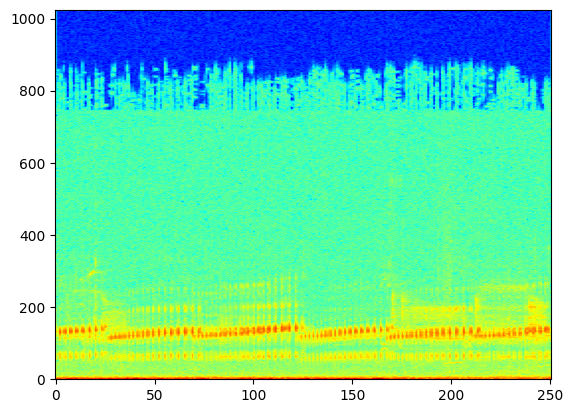

In [21]:
from tools.audio import *
from tools.relax import prepare_audio, mask_audio, apply_relax, plot_results, extract_masks_features
from prediction import load_beats_model

### Parameters 
# Audio
#f = r'audio\5-172299-A-5.wav'
f = r'audio\5-187201-B-4.wav'

#1-137-A-32.wav Regular, strong on temporal masking
#1-96890-A-37.wav Regular, strong on temporal masking
#1-22804-A-46.wav Regular, strong on frequency masking
#1-34119-B-1.wav Irregular, strong on temporal frequecy masking
#1-51805-C-33.wav Irregular, strong on temporal masking
#3-95695-A-5.wav Very hard to guess
#3-118972-B-41.wav Nothing is really clear, so who knows
#5-187201-B-4.wav Frequency "easy" one, just to see if we get it
# Masking
T = 50
F = 0
min_t = 10
min_f = 0
n_masks = 200
n_parts_t = 4
n_parts_f = 0
# BEATS model
model_path = 'beats_env/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

audio, sr, cpx_spec, spec = prepare_audio(f, plot=True, play=True)

In [42]:
print(type(n_parts_f))
masked_audio_inputs, all_masks, h_star = mask_audio(audio, sr, cpx_spec, T, F, n_masks, beats_model, min_t, min_f, n_parts_t, n_parts_f)

<class 'int'>
<class 'int'>


In [43]:
audios_per_batch = 10
n_batches = int(n_masks/audios_per_batch)
h_masks = extract_masks_features(masked_audio_inputs, beats_model, n_batches=n_batches)

100%|██████████| 20/20 [05:20<00:00, 16.01s/it]


In [44]:
R, U, W, s = apply_relax(masked_audio_inputs, all_masks, h_masks, h_star, beats_model)

100%|██████████| 400/400 [06:34<00:00,  1.01it/s]


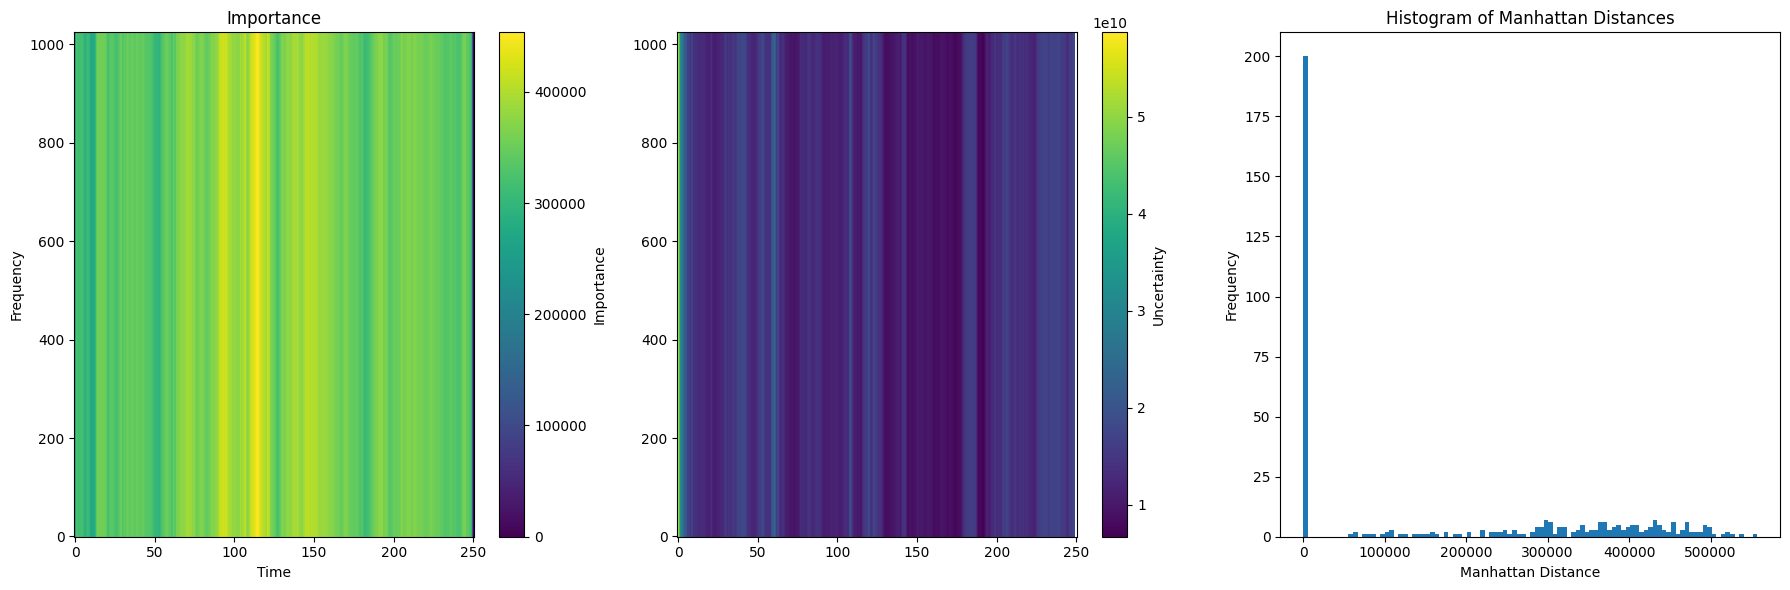

In [45]:
plot_results(R, U, W, s)